<a href="https://colab.research.google.com/github/sheeerth/blackjack/blob/main/BLACKJACK_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SETUP

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Flatten, Dropout

stacks = 40000
players = 1
num_decks = 1

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]
feature_list = ['player_total_initial', 'hit?', 'has_ace', 'dealer_card_num']

dealer_card_feature = []
player_card_feature = []
player_live_total = []
player_live_action = []
player_results = []
dealer_bust = []

first_game = True
prev_stack = 0
stack_num_list = []
new_stack = []
card_count_list = []
games_played_with_stack = []

## HELPERS FUNCTION

In [ ]:
# Function get permutation of combination ace iin cards set and check which is lower than 21 

def get_ace_values(temp_list):
    sum_array = np.zeros((2**len(temp_list), len(temp_list)))
    for i in range(len(temp_list)):
        n = len(temp_list) - i
        half_len = int(2**n * 0.5)
        for rep in range(int(sum_array.shape[0]/half_len/2)):
            sum_array[rep*2**n : rep*2**n+half_len, i] = 1
            sum_array[rep*2**n+half_len : rep*2**n+half_len*2, i] = 11
    return [int(s) for s in np.sum(sum_array, axis=1)]

# Conver ace list 

def ace_values(num_aces):
    temp_list = []
    for i in range(num_aces):
        temp_list.append([1,11])
    return get_ace_values(temp_list)

# Make a deck
def make_decks(num_decks, card_types):
    new_deck = []
    for i in range(num_decks):
        for j in range(4):
            new_deck.extend(card_types)
    random.shuffle(new_deck)
    return new_deck

# Total up value of hand
def total_up(hand):
    aces = 0
    total = 0
    
    for card in hand:
        if card != 'A':
            total += card
        else:
            aces += 1
            
    ace_value_list = ace_values(aces)
    final_totals = [i+total for i in ace_value_list if i+total<=21]
    
    if final_totals == []:
        return min(ace_value_list) + total
    else:
        return max(final_totals)
    
# Play a game of blackjack (after the cards are dealt)
def play_game(dealer_hand, player_hands, blackjack, curr_player_results, dealer_cards, hit_stay, card_count, dealer_bust):
    action = 0
    # Dealer checks for 21
    if set(dealer_hand) == blackjack:
        for player in range(players):
            if set(player_hands[player]) != blackjack:
                curr_player_results[0,player] = -1
            else:
                curr_player_results[0,player] = 0
    else:
        for player in range(players):
            # Players check for 21
            if set(player_hands[player]) == blackjack:
                curr_player_results[0,player] = 1
            else:
                # Hit randomly, check for busts
                if (hit_stay >= 0.5) and (total_up(player_hands[player]) != 21):
                    player_hands[player].append(dealer_cards.pop(0))
                    card_count[player_hands[player][-1]] += 1
                    
                    action = 1
                    live_total.append(total_up(player_hands[player]))
                    if total_up(player_hands[player]) > 21:
                        curr_player_results[0,player] = -1

    # Dealer hits based on the rules
    card_count[dealer_hand[-1]] += 1
    while total_up(dealer_hand) < 17:
        dealer_hand.append(dealer_cards.pop(0))
        card_count[dealer_hand[-1]] += 1
        
    # Compare dealer hand to players hand but first check if dealer busted
    if total_up(dealer_hand) > 21:
        dealer_bust.append(1)
        for player in range(players):
            if curr_player_results[0,player] != -1:
                curr_player_results[0,player] = 1
    else:
        dealer_bust.append(0)
        for player in range(players):
            if total_up(player_hands[player]) > total_up(dealer_hand):
                if total_up(player_hands[player]) <= 21:
                    curr_player_results[0,player] = 1
            elif total_up(player_hands[player]) == total_up(dealer_hand):
                curr_player_results[0,player] = 0
            else:
                curr_player_results[0,player] = -1
                
    return curr_player_results, dealer_cards, action, card_count, dealer_bust

def deal_card(player_hands, dealer_cards, player):
  player_hands[player].append(dealer_cards.pop(0))
  card_count[player_hands[player][-1]] += 1

  return player_hands, dealer_cards, player

## CREATE TRAIN SET

In [ ]:
for stack in range(stacks):
    games_played = 0
    card_count = {2: 0, 3: 0, 4: 0, 5: 0,  6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 'A': 0}
    blackjack = set(['A',10])
    dealer_cards = make_decks(num_decks, card_types)

    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]
        live_total = []
        live_action = []

        for player, hand in enumerate(player_hands):
          player_hands, dealer_cards, player = deal_card(player_hands, dealer_cards, player)
            
        dealer_hand.append(dealer_cards.pop(0))
        card_count[dealer_hand[-1]] += 1
        
        for player, hand in enumerate(player_hands):
            player_hands, dealer_cards, player = deal_card(player_hands, dealer_cards, player)
            
        dealer_hand.append(dealer_cards.pop(0))
        
        live_total.append(total_up(player_hands[player]))
        
        if stack < stacks/2:
            hit_stay = 1
        else:
            hit_stay = 0
            
        curr_player_results, dealer_cards, action, card_count, dealer_bust = play_game(dealer_hand, player_hands, blackjack, curr_player_results, dealer_cards, hit_stay, card_count, dealer_bust)
        
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))
        player_live_total.append(live_total)
        player_live_action.append(action)
        
        if stack != prev_stack:
            new_stack.append(1)
        else:
            new_stack.append(0)
            if first_game == True:
                first_game = False
            else:
                games_played += 1
            
        stack_num_list.append(stack)
        games_played_with_stack.append(games_played)
        card_count_list.append(card_count.copy())
        prev_stack = stack

## SOMETHINK

In [ ]:
model_df = pd.DataFrame()
model_df['dealer_card'] = dealer_card_feature
model_df['player_total_initial'] = [total_up(i[0][0:2]) for i in player_card_feature]
model_df['hit?'] = player_live_action

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df['has_ace'] = has_ace

dealer_card_num = []
for i in model_df['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    else:
        dealer_card_num.append(i)
model_df['dealer_card_num'] = dealer_card_num

model_df['Y'] = [i[0] for i in player_results]
lose = []
for i in model_df['Y']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df['lose'] = lose

correct = []
for i, val in enumerate(model_df['lose']):
    if val == 1:
        if player_live_action[i] == 1:
            correct.append(0)
        else:
            correct.append(1)
    else:
        if player_live_action[i] == 1:
            correct.append(1)
        else:
            correct.append(0)
model_df['correct_action'] = correct

card_count_df = pd.concat([pd.DataFrame(new_stack, columns=['new_stack']), pd.DataFrame(games_played_with_stack, columns=['games_played_with_stack']), pd.DataFrame.from_dict(card_count_list), pd.DataFrame(dealer_bust, columns=['dealer_bust'])], axis=1)
model_df = pd.concat([model_df, card_count_df], axis=1)

## TRAIN SET ANALISE

Int64Index([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64', name='player_total_initial') [0.27806563 0.29297125 0.29571894 0.31301536 0.34736701 0.38805815
 0.41476307 0.43324534 0.319265   0.31032809 0.30362398 0.29660742
 0.29691414 0.36118555 0.42859668 0.47886773 0.53095247]


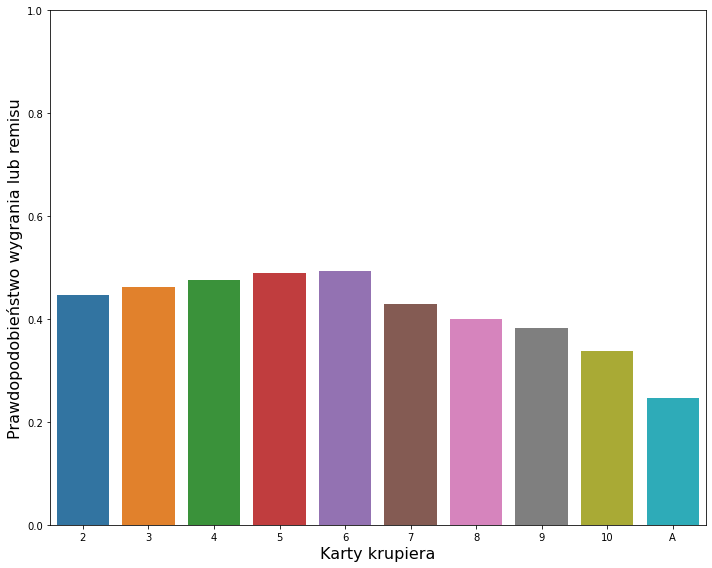

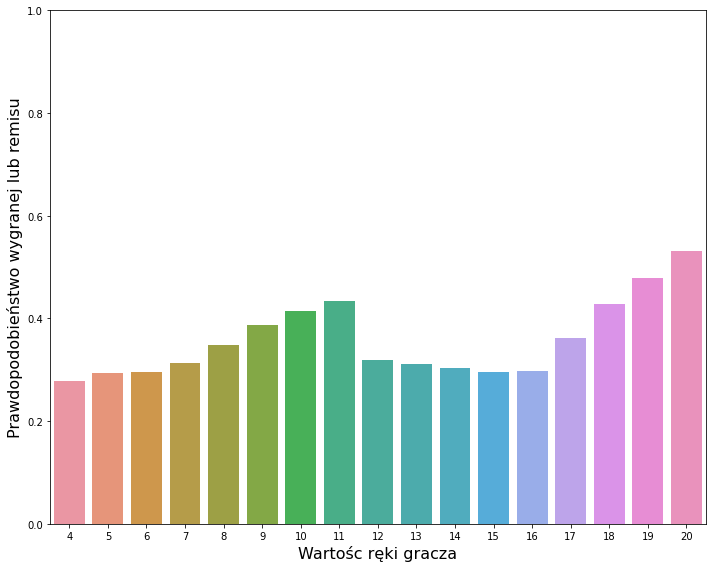

In [ ]:
data = 1 - (model_df.groupby(by='dealer_card').sum()['lose'] /\
            model_df.groupby(by='dealer_card').count()['lose'])

fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=data.index, 
                 y=data.values)
ax.set_xlabel("Karty krupiera",fontsize=16)
ax.set_ylabel("Prawdopodobieństwo wygrania lub remisu",fontsize=16)
ax.set_ylim(0.0, 1.0)

plt.tight_layout()
plt.savefig(fname='dealer_card_probs_test', dpi=150)

data = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] /\
            model_df.groupby(by='player_total_initial').count()['lose'])

fig, ax = plt.subplots(figsize=(10,8))
print(data[:-1].index, data[:-1].values)
ax = sns.barplot(x=data[:-1].index, y=data[:-1].values)
ax.set_xlabel("Wartośc ręki gracza",fontsize=16)
ax.set_ylabel("Prawdopodobieństwo wygranej lub remisu",fontsize=16)
ax.set_ylim(0.0, 1.0)

plt.tight_layout()
plt.savefig(fname='player_hand_probs_test', dpi=200)

## CREATE MODEL

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(train_X.shape[1]+1))
  model.add(Dense(8, activation='softmax'))
  model.add(Dense(16))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(32))
  model.add(Dense(8))
  model.add(Dense(4))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam')

  return model

## LEARN AI

In [ ]:
model_name = 'blackjack_model.h5'

feature_list = [i for i in model_df.columns if i not in ['dealer_card', 'Y','lose', 'correct_action', 'dealer_bust', 'dealer_bust_pred', 'new_stack', 'games_played_with_stack', 2,3,4,5,6,7,8,9,10,'A', 'blackjack?']]
train_X = np.array(model_df[feature_list])
train_Y = np.array(model_df['correct_action']).reshape(-1,1)

print(feature_list)
print('\n')

try: 
  model = load_model(model_name) 
  
except:
  model = create_model()

model.fit(train_X, train_Y, epochs=800, batch_size=128, verbose=1)


model.save(model_name)

pred_Y_train = model.predict(train_X)
actuals = train_Y[:,-1]

['player_total_initial', 'hit?', 'has_ace', 'dealer_card_num']


Epoch 1/800
2015/2015 [==============================] - 4s 2ms/step - loss: 0.5416
Epoch 2/800
2015/2015 [==============================] - 3s 2ms/step - loss: 0.5416
Epoch 3/800
2015/2015 [==============================] - 3s 2ms/step - loss: 0.5415
Epoch 4/800
2015/2015 [==============================] - 3s 2ms/step - loss: 0.5414
Epoch 5/800
2015/2015 [==============================] - 3s 2ms/step - loss: 0.5414
Epoch 6/800
2015/2015 [==============================] - 3s 2ms/step - loss: 0.5414
Epoch 7/800
2015/2015 [==============================] - 3s 2ms/step - loss: 0.5413
Epoch 8/800
2015/2015 [==============================] - 3s 2ms/step - loss: 0.5414
Epoch 9/800
2015/2015 [==============================] - 3s 2ms/step - loss: 0.5414
Epoch 10/800
2015/2015 [==============================] - 3s 2ms/step - loss: 0.5414
Epoch 11/800
2015/2015 [==============================] - 3s 2ms/step - loss: 0.5414
Epoch 12/

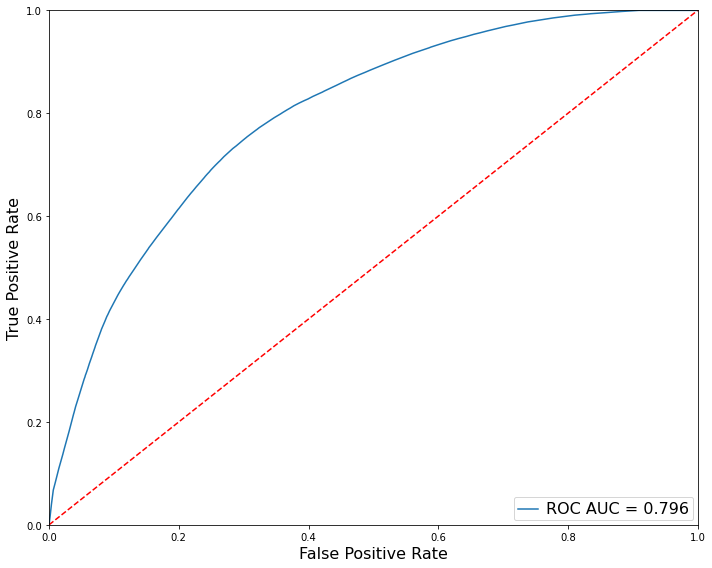

In [ ]:

# Plot ROC Curve

fpr, tpr, threshold = metrics.roc_curve(actuals, pred_Y_train)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(fpr, tpr, label = ('ROC AUC = %0.3f' % roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax.set_xlabel("False Positive Rate",fontsize=16)
ax.set_ylabel("True Positive Rate",fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize=16)
plt.tight_layout()
plt.savefig(fname='roc_curve_blackjack', dpi=150)
plt.show()

## TEST MODEL

In [ ]:

# Given the relevant inputs, the function below uses the neural net to make a prediction
# and then based on that prediction, decides whether to hit or stay

def model_decision(model, player_sum, has_ace, dealer_card_num, new_stack, games_played):
    input_array = np.array([player_sum, 0, has_ace, 
                            dealer_card_num, new_stack, 
                            games_played]).reshape(1,-1)
    # cc_array = pd.DataFrame.from_dict([card_count])
    # input_array = np.concatenate([input_array, cc_array], axis=1)
    predict_correct = model.predict(input_array)
    if predict_correct >= 0.52:
        return 1, predict_correct
    else:
        return 0, predict_correct
    
def model_decision_old(model, player_sum, has_ace, dealer_card_num):
    input_array = np.array([player_sum, 0, has_ace, dealer_card_num]).reshape(1,-1)
    predict_correct = model.predict(input_array)
    if predict_correct >= 0.52:
        return 1
    else:
        return 0

In [ ]:
stacks = 2000
players = 1
num_decks = 1

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_feature = []
player_card_feature = []
player_results = []

for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cards = make_decks(num_decks, card_types)
    games_played = 0;

    if stack != prev_stack:
        temp_new_stack = 1
    else:
        temp_new_stack = 0

        # Make a dict for keeping track of the count for a stack
    # card_count = {2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 'A': 0}

    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]

        # Deal FIRST card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        # Deal SECOND card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))

        # Dealer checks for 21
        if set(dealer_hand) == blackjack:
            for player in range(players):
                if set(player_hands[player]) != blackjack:
                    curr_player_results[0,player] = -1
                else:
                    curr_player_results[0,player] = 0
        else:
            for player in range(players):
                # Players check for 21
                if set(player_hands[player]) == blackjack:
                    curr_player_results[0,player] = 1
                else:
                     # Neural net decides whether to hit or stay
                        if 'A' in player_hands[player][0:2]:
                            ace_in_hand = 1
                        else:
                            ace_in_hand = 0
                        if dealer_hand[0] == 'A':
                            dealer_face_up_card = 11
                        else:
                            dealer_face_up_card = dealer_hand[0]

                        while (model_decision_old(model, total_up(player_hands[player]), 
                                                  ace_in_hand, dealer_face_up_card,
                                                  # temp_new_stack, games_played, 
                                                  # card_count
                                                 ) == 1) and (total_up(player_hands[player]) != 21):
                            player_hands[player].append(dealer_cards.pop(0))
                            action = 1
                            live_total.append(total_up(player_hands[player]))
                            if total_up(player_hands[player]) > 21:
                                curr_player_results[0,player] = -1
                                break
        
        # Dealer hits based on the rules
        while total_up(dealer_hand) < 17:
            dealer_hand.append(dealer_cards.pop(0))
        # Compare dealer hand to players hand but first check if dealer busted
        if total_up(dealer_hand) > 21:
            for player in range(players):
                if curr_player_results[0,player] != -1:
                    curr_player_results[0,player] = 1
        else:
            for player in range(players):
                if total_up(player_hands[player]) > total_up(dealer_hand):
                    if total_up(player_hands[player]) <= 21:
                        curr_player_results[0,player] = 1
                elif total_up(player_hands[player]) == total_up(dealer_hand):
                    curr_player_results[0,player] = 0
                else:
                    curr_player_results[0,player] = -1
        print('player: ' + str(total_up(player_hands[player])),
             'dealer: ' + str(total_up(dealer_hand)),
             'result: ' + str(curr_player_results)
            )    
        
        # Track features
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))
        games_played =+ 1

Streaming output truncated to the last 5000 lines.
player: 19 dealer: 26 result: [[1.]]
player: 17 dealer: 22 result: [[1.]]
player: 18 dealer: 17 result: [[1.]]
player: 22 dealer: 26 result: [[-1.]]
player: 21 dealer: 20 result: [[1.]]
player: 24 dealer: 17 result: [[-1.]]
player: 24 dealer: 19 result: [[-1.]]
player: 18 dealer: 23 result: [[1.]]
player: 21 dealer: 19 result: [[1.]]
player: 20 dealer: 24 result: [[1.]]
player: 21 dealer: 24 result: [[1.]]
player: 26 dealer: 20 result: [[-1.]]
player: 21 dealer: 18 result: [[1.]]
player: 22 dealer: 20 result: [[-1.]]
player: 21 dealer: 20 result: [[1.]]
player: 21 dealer: 20 result: [[1.]]
player: 20 dealer: 18 result: [[1.]]
player: 23 dealer: 19 result: [[-1.]]
player: 25 dealer: 20 result: [[-1.]]
player: 21 dealer: 18 result: [[1.]]
player: 19 dealer: 20 result: [[-1.]]
player: 23 dealer: 19 result: [[-1.]]
player: 18 dealer: 25 result: [[1.]]
player: 20 dealer: 18 result: [[1.]]
player: 18 dealer: 19 result: [[-1.]]
player: 21 dea

In [ ]:
model_test_df = pd.DataFrame()
model_test_df['dealer_card'] = dealer_card_feature
model_test_df['player_total_initial'] = [total_up(i[0][0:2]) for i in player_card_feature]
model_test_df['Y'] = [i[0] for i in player_results]

lose = []
for i in model_test_df['Y']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_test_df['lose'] = lose

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_test_df['has_ace'] = has_ace

dealer_card_num = []
for i in model_test_df['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    else:
        dealer_card_num.append(i)
model_test_df['dealer_card_num'] = dealer_card_num

In [ ]:
sum(pd.DataFrame(player_results)[0].value_counts())

11682

In [ ]:
pd.DataFrame(player_results)[0].value_counts()

-1.0    6060
 1.0    4615
 0.0    1007
Name: 0, dtype: int64

## ANALISE TEST SET

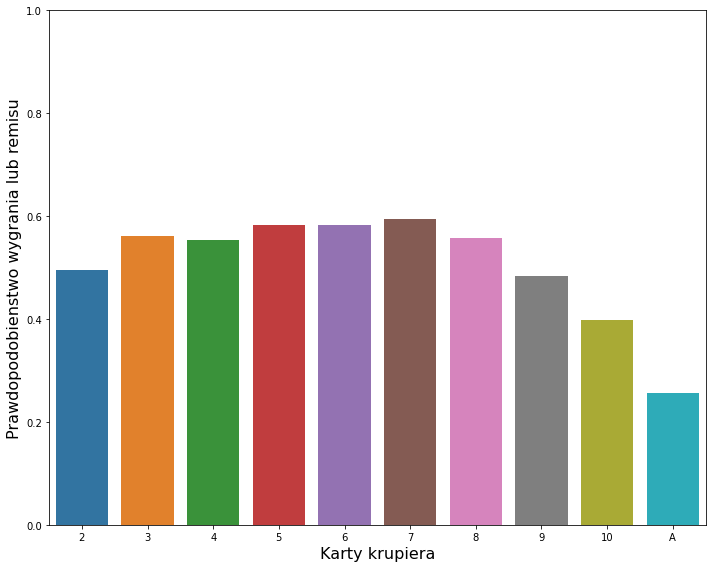

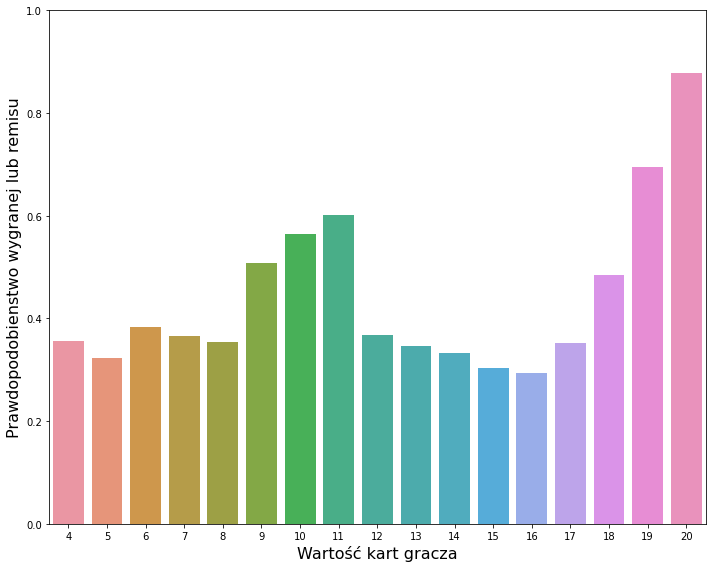

In [ ]:
data = 1 - (model_test_df.groupby(by='dealer_card').sum()['lose'] /\
            model_test_df.groupby(by='dealer_card').count()['lose'])

fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=data.index, 
                 y=data.values)
ax.set_xlabel("Karty krupiera",fontsize=16)
ax.set_ylabel("Prawdopodobienstwo wygrania lub remisu",fontsize=16)
ax.set_ylim(0.0, 1.0)

plt.tight_layout()
plt.savefig(fname='dealer_card_probs', dpi=150)

data = 1 - (model_test_df.groupby(by='player_total_initial').sum()['lose'] /\
            model_test_df.groupby(by='player_total_initial').count()['lose'])

fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=data[:-1].index,
                 y=data[:-1].values)
ax.set_xlabel("Wartość kart gracza",fontsize=16)
ax.set_ylabel("Prawdopodobienstwo wygranej lub remisu",fontsize=16)
ax.set_ylim(0.0, 1.0)

plt.tight_layout()
plt.savefig(fname='player_hand_probs', dpi=150)